In [77]:
import pandas as pd
from jfit import *
from jplot import *
from jFermi2.ImgAnalysis.SingleSiteAnalysis import *
plt.rcParams['figure.dpi'] = 100

import warnings
warnings.filterwarnings('ignore')

def loadDensityImagesArr(_df):
    # Assumes _df has already been cut/parsed as necessary to the final dataset
    # Get doublons, holes, etc. densities from the images 
    img_d_arr = np.zeros((len(_df),64,64))
    img_h_arr = np.zeros((len(_df),64,64))
    img_s_arr = np.zeros((len(_df),64,64))
    img_n_arr = np.zeros((len(_df),64,64))
    for jj, _id in enumerate(_df.index):
        img1 = np.loadtxt(os.path.join('Data', _df.loc[_id, "Run Name"][:-5]+'_binned1.txt'))
        img2 = np.loadtxt(os.path.join('Data', _df.loc[_id, "Run Name"][:-5]+'_binned2.txt'))
        img_h, img_d, _ = get_n_img(img1 + img2, [0, 2])
        img_h, img_s, _ = get_n_img(img1 + img2, [0, 1])
        img_d_arr[jj] =img_d
        img_h_arr[jj] =img_h
        img_s_arr[jj] =img_s
        img_n_arr[jj] =img_s + 2*img_d
    return [img_h_arr,img_s_arr,img_d_arr,img_n_arr]

def ret_average(df, xvar, yvar):
    # Returns dataset (df) averaged values, and standard errors for data
    _grp = df.groupby(xvar)
    yval = _grp.mean()[yvar].values
    ystd = _grp.std()[yvar].values
    ycnt = _grp.count()[yvar].values
    xval = _grp.mean().index.astype(float)
    return xval, yval, ystd/np.sqrt(ycnt-1), ycnt

def get_nijkl_SymAvg(img1, img2,img3, img4):
    # want to return 1 at a point if the 4 arrays have 1 1 1 1 in order 
        # img1 anchor point, img2 above, img3 above and right, img4 right 
        # and symmetric averages across rotating this pattern around the anchor point. 
    _nijkl = (1/4)*(get_nij(img2, img1,0,1)*get_nij(img3, img1,1,1)*get_nij(img4, img1,1,0) +
                    get_nij(img2, img1,1,0)*get_nij(img3, img1,1,-1)*get_nij(img4, img1,0,-1) + 
                    get_nij(img2, img1,0,-1)*get_nij(img3, img1,-1,-1)*get_nij(img4, img1,-1,0) + 
                    get_nij(img2, img1,-1,0)*get_nij(img3, img1,-1,1)*get_nij(img4, img1,0,1) )
        # Note get_nij shifts image 1 not image 2, then multiplies, so if we want to return "1" when we have the right pattern
        # relative to the anchor point, then we have to shift image 2, and then multiply by image 1 which is unshifted. 
    # This gives probability of having this specific pattern around the anchor pixel (if its in all 4 directions, this equals 1)
    return _nijkl

def patternCountPerImg(_imgsArr, _patternArr):
    # Returns an array of images with number of instances of pattern in plaquette 
    # _patternArr should be an array of 4 selections, 0=hole, 1=singlons, etc. 
    countArr = np.asarray([np.sum(get_nijkl_SymAvg(_imgsArr[_patternArr[0]][ii],_imgsArr[_patternArr[1]][ii],
                                                   _imgsArr[_patternArr[2]][ii],_imgsArr[_patternArr[3]][ii])) for ii in range(len(_imgsArr[0]))])
    return countArr
    
def analysis_plaquetteProbability(tag, xvar, csvName):
    df = pd.read_csv(csvName)
    df = df[df['Valid']==1]
    _df = df[df['Tag']==tag]

    imgsArr = loadDensityImagesArr(_df)
    
    # Search for a specific pattern in the data 0 is holes, 1 is singlons, 2 is doublons, 3 is density 
        # labelled in order bottom left, top left, top right, bottom right in plaquette 
        # will return 1/4 on each site that is involved in a plaquette of a specific exact configuration (with type x in specific corner)
    # Doublon checkerboard exact
    # patternsSoughtArr = [[2,0,2,0],[0,2,0,2]] 
    # patternsComparedArr = [[2,0,2,0],[2,2,0,0],[2,0,0,2],[0,2,0,2],[0,0,2,2],[0,2,2,0]]
    
    # Almost doublon checkerboard, but also possibly with singlons thrown in
    patternsSoughtArr = [[2,0,2,0],[0,2,0,2],[2,1,2,0],[0,2,1,2],[2,0,2,1],[1,2,0,2],[2,1,2,1],[1,2,1,2]] 
    patternsComparedArr = [[2,0,2,0],[2,2,0,0],[2,0,0,2],[0,2,0,2],[0,0,2,2],[0,2,2,0],
                          [2,1,2,0],[2,2,1,0],[2,1,0,2],[1,2,0,2],[1,0,2,2],[1,2,2,0],
                          [2,0,2,1],[2,2,0,1],[2,0,1,2],[0,2,1,2],[0,1,2,2],[0,2,2,1],
                          [2,1,2,1],[2,2,1,1],[2,1,1,2],[1,2,1,2],[1,1,2,2],[1,2,2,1]]
    
    patCount = np.sum([patternCountPerImg(imgsArr, patternsSoughtArr[ii]) for ii in range(len(patternsSoughtArr))],axis=0)
    patBaseline= np.sum([patternCountPerImg(imgsArr, patternsComparedArr[ii]) for ii in range(len(patternsComparedArr))],axis=0)
    
    _df['patCount'] = np.asarray(patCount)
    _df['patBaseline'] = np.asarray(patBaseline)
    
    xdat, patCountdat, patCountstd, patCountNumImgs = ret_average(_df, xvar, 'patCount')
    xdat, patBaselinedat, patBaselinestd, patBaselineNumImgs = ret_average(_df, xvar, 'patBaseline')
    patCountncnt = patCountdat*patCountNumImgs # Assumes total number is average times number of datapoints
    patBaselinencnt = patBaselinedat*patBaselineNumImgs
    
    ydat = patCountdat/patBaselinedat
    # Fractional uncertainty on some counting process is expected Poisson noise, from both numerator and denominator 
    ystd = ydat*np.sqrt(1/patCountncnt + 1/patBaselinencnt) # Should double check this 
    
    if False: # plot some things
        print(patCountncnt)
        print(patBaselinencnt)
        
        ii0=0 # Which image to plot
        nimgtest = get_nijkl_SymAvg(imgsArr[2][ii0],imgsArr[0][ii0],imgsArr[2][ii0],imgsArr[0][ii0])+get_nijkl_SymAvg(imgsArr[0][ii0],imgsArr[2][ii0],imgsArr[0][ii0],imgsArr[2][ii0])
        ndtest = imgsArr[2][ii0]
        plt.imshow(nimgtest, vmin=0, vmax=1)
        plt.show()
        plt.imshow(ndtest)
        plt.show()
        print(np.sum(nimgtest))
        print(np.sum(ndtest))
    
    return xdat, ydat, ystd

def simplePlot(xdat, ydat, ystd, xlab, ylab):
    fig, ax = plt.subplots(1,figsize=(3, 3))
    jerrbar(plt.gca(), xdat, ydat, yerr=ystd)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.show()

In [78]:
csvNameGlob = 'AttractiveCorrelationOptimization.csv'

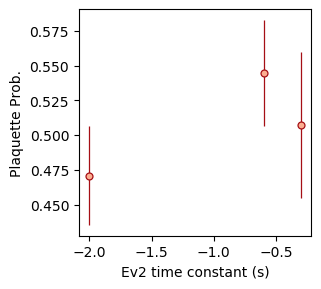

In [79]:
xlab = 'Ev2 time constant (s)'; ylab = 'Plaquette Prob.'
tag = 'FE_tau1'
xvar = 'FE_otherTau_s'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

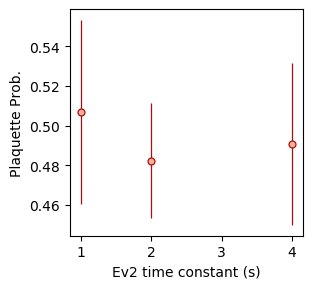

In [80]:
xlab = 'Ev2 time constant (s)'; ylab = 'Plaquette Prob.'
tag = 'FE2_time'
xvar = 'FE2_totT_s'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

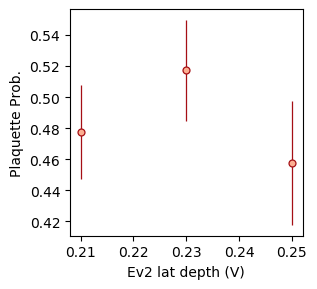

In [81]:
xlab = 'Ev2 lat depth (V)'; ylab = 'Plaquette Prob.'
tag = 'evGap'
xvar = 'FL_EvOpenGapDepth_V'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

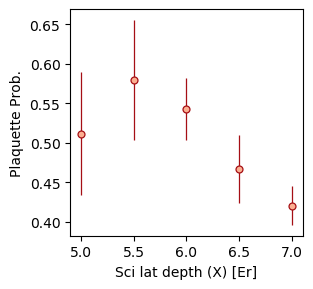

In [82]:
# Loading lat depth (Er)
xlab = 'Sci lat depth (X) [Er]'; ylab = 'Plaquette Prob.'
tag = 'latDepth'
xvar = 'XLat_Er'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

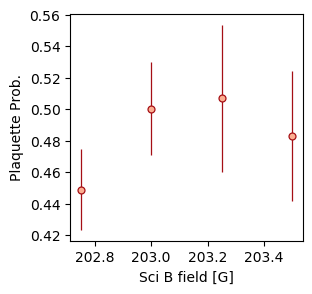

In [83]:
# Loading lat B field 
xlab = 'Sci B field [G]'; ylab = 'Plaquette Prob.'
tag = 'BField'
xvar = 'BFinal_G'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

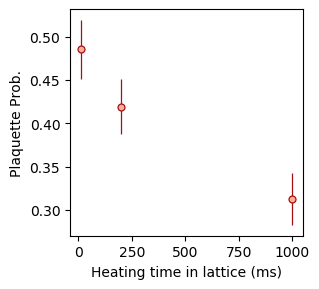

In [84]:
# Heating time
xlab = 'Heating time in lattice (ms)'; ylab = 'Plaquette Prob.'
tag = 'heatingTime'
xvar = 'heatingTime_ms'
xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
simplePlot(xdat, ydat, ystd, xlab, ylab)

In [ ]:
# # Test setup to see what sum gives for various configurations 

# imgTest = np.asarray([[0,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,1,0,0,0],[0,0,0,1,0]])
# imgTestbar = 1-imgTest
# plt.imshow(imgTest)
# plt.show()
# plt.imshow(imgTestbar)
# plt.show()
# sym =get_nijkl_SymAvg(imgTest ,imgTestbar,imgTest ,imgTestbar )+get_nijkl_SymAvg(imgTestbar,imgTest ,imgTestbar,imgTest  )
# plt.imshow(sym, vmin=0, vmax = 1)
# plt.show()
# print(np.sum(sym))

In [ ]:
# ## Single analysis code

# xlab = 'Ev2 time constant (s)'; ylab = 'Plaquette Prob.'
# tag = 'FE_tau1'
# xvar = 'FE_otherTau_s'
# xdat, ydat, ystd = analysis_plaquetteProbability(tag, xvar, csvNameGlob)
# simplePlot(xdat, ydat, ystd, xlab, ylab)

In [ ]:
# ## Multi analysis code

# tags = ['varyMask'+str(ii) for ii in ['', 2, 3, 4, 5]]
# xvar = 'maskDimRatio'
# labvar = 'clovDimRatio'

# # get data
# data = [analysis_plaquetteProbability(tag, xvar, csvNameGlob) for tag in tags]

# # get labels
# df = pd.read_csv(csvNameGlob)
# labelsArr = [df[df['Tag']==tags[ii]][labvar].unique()[0] for ii in range(len(tags))]

# # plot full dataset 
# for ii, tag in enumerate(tags):
#     jerrbar(plt.gca(), data[ii][0], data[ii][1], yerr=data[ii][2], label=labelsArr[ii], color=jcc[jcc_keys[ii*4%16]])
# plt.legend()